# 코드 복사

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
# 이번 프로젝트에서는 각 픽셀을 -1, 1로 정규화시켜서 사용할 예정이므로, 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠줍니다.

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(60000, 28, 28)

In [6]:
#  Fashion MNIST 데이터는 흑백 이미지이므로, 채널 값은 1이죠. 따라서 데이터셋의 shape 마지막에 1을 추가해 주도록 하겠습니다.

train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

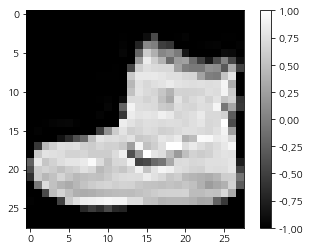

In [7]:
# 한번 첫 번째 데이터를 꺼내서 어떻게 생겼는지 확인해 볼까요?

plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar() # 오른쪽에 각 픽셀의 값과 그에 따른 색도 확인
"""
픽셀에는 우리가 정규화 해준 대로 -1 ~ 1 사이의 값을 가지고, -1이 가장 어두운 검은색, 1이 가장 밝은 흰색을 띤다고 표시
"""
plt.show()

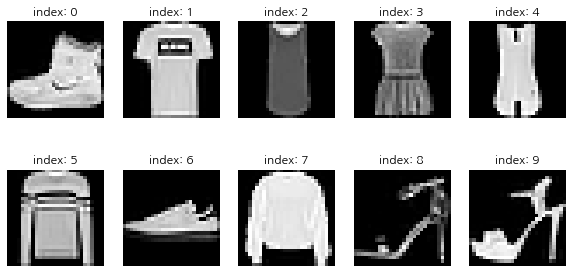

In [8]:
# 여러 개 확인

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1) # plt.subplot(row, col, index)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off') #  불필요한 축을 지우기
plt.show()

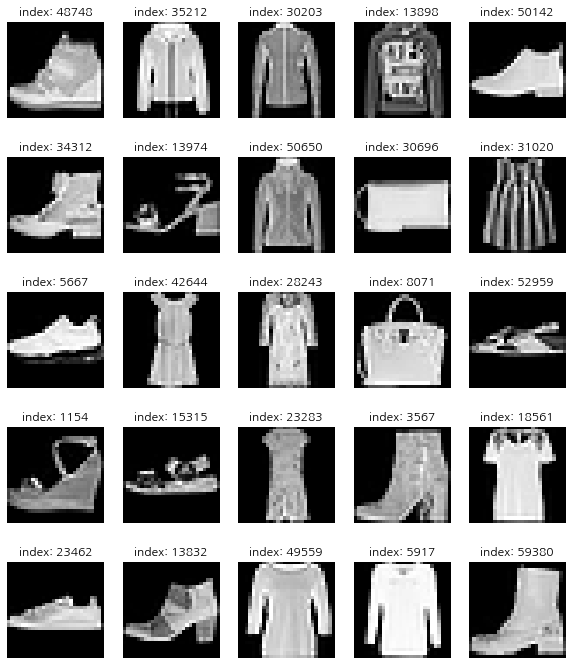

In [9]:
# 이미지 25개를 5*5배열로 랜덤 출력

plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 60000)
    plt.imshow(train_x[random_index].reshape(28, 28), cmap='gray')
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [10]:
# 모델에 넣어서 학습시켜야 하니, 편하게 사용할 수 있도록 텐서플로우의 Dataset을 이용해 준비
# 우리가 매번 모델에게 직접 섞어서 넣어주지 않아도 됩니다.

BUFFER_SIZE = 60000 # 전체 데이터를 섞기 위해 60,000으로 설정
BATCH_SIZE = 256    # 모델이 한 번에 학습할 데이터의 양 

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

tf.data.Dataset 모듈의 `from_tensor_slices()` 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있습니다.  
위 코드는 `train_x`라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 합니다. 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋습니다.

In [11]:
# DCGAN 만들기

def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) # 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화
    model.add(layers.LeakyReLU()) # 활성화 함수

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh')) # -1 ~ 1 이내의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함

    return model

In [12]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

`shape=(1, 100)`의 형상을 가지는 랜덤 노이즈 벡터를 생성해서 결과물을 한번 만들기  
아직 모델이 학습되지 않았으니, 아마 결과물도 큰 의미가 있지는 않을 것  
`tf.random.normal`을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있다.

In [13]:
noise = tf.random.normal([1, 100])

텐서플로우 2.0 버전에서는 레이어와 모델에 call 메소드를 구현해 놓기 때문에, 방금 만들어진 생성자 모델에 입력값으로 노이즈를 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성됩니다 (내부적으로는 생성자의 call 함수가 호출됩니다).

단, 지금은 학습하는 중이 아니니 `training=False`를 설정해 주어야 합니다! Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에 `training=False`을 주어야 올바른 결과를 얻을 수 있습니다.

In [14]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

`matplotlib` 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정해서 `(28, 28)` shape의 이미지를 꺼낼 수 있도록 해야 합니다.

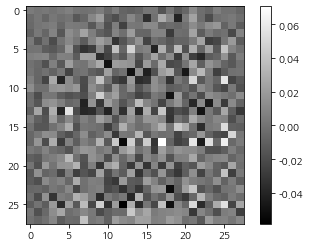

In [15]:
# 시각화, 아직 학습 전이라 노이즈 같은 이미지 생성됨.

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

### 판별자 구현
- 가짜 이미지와 진짜 이미지를 입력받으면 각 이미지 별로 '진짜라고 판단하는 정도'값을 출력해야 한다.  
입력은 (28, 28, 1) 크기의 이미지  
출력은 단 하나의 숫자(진짜라고 판단하는 정도)

In [16]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [17]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [18]:
# 아까 생성했던 가짜 이미지를 판별자에 입력
# >> 텐서 형태로 출력. 아직은 아무런 의미가 없는 값

decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0025451]], dtype=float32)>

### 손실 함수와 최적화 함수

In [19]:
# tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정
# from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 
# 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산 가능

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

**generator_loss**  
`generator_loss`는 `fake_output`이 1에 가까워지기를 바라므로, 다음과 같이 `tf.ones_like`와의 교차 엔트로피값을 계산하면 됩니다.
즉, `cross_entropy(tf.ones_like(fake_output), fake_output)` 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가집

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

**discriminator_loss**  
`real_output` 값은 1에 가까워지기를, `fake_output` 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산합니다. `real_output`은 1로 채워진 벡터와, `fake_output`은 0으로 채워진 벡터와 비교하면 되겠죠!

최종 `discriminator_loss` 값은 이 둘을 더한 값

In [21]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

**discriminator accuracy**  
판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산  
real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적  
판별자가 real accuracy, fak accuracy를 1.0으로 예측하면 좋나? 아니다. 생성자가 제대로 만들고 있지 못함.  

ex.) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 라면,  

(1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별  
`>> tf.Tensor([False, False, True, True])`  
(2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환  
`>> tf.Tensor([0.0, 0.0, 1.0, 1.0])`  
(3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산  
`>> 0.5`

In [22]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [23]:
# 최적화 함수 설정

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [24]:
# 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인
# 샘플은 한 번에 16장
# 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈 생성
# 즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 두도록.

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [25]:
@tf.function
def train_step(images):  #(1) 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
    #(2) 생성자 입력 노이즈: generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  
    # (3) tf.GradientTape() 오픈 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # (4) generated_images 생성: generator가 noise를 입력받은 후 generated_images 생성
        generated_images = generator(noise, training=True)  

        #(5) discriminator 판별: discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후
        # real_output, fake_output 출력
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산: fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산: fake_output, real_output으로 정확도 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산: gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습: 계산된 gradient를 optimizer에 입력해 가중치 갱신
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값: 이번 스텝에 계산된 loss와 accuracy를 리턴
    # 이러한 일련의 과정을 통해 한 번의 train_step이 끝나게 됩니다. 

In [26]:
# 그러면, 이렇게 한 단계씩 학습할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수를 만들어 보죠.
# 아까 만들어 놓았던 고정된 seed를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있습니다.

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [27]:
# train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 
# 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 만들어 봅시다. 
# 예를 들어 생성자의 loss의 history는 history['gen_loss']로 접근할 수 있는 list로 관리할 예정입니다.

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

`tf.train.Checkpoint`를 활용하면 매번 모델을 직접 저장해주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리  
checkpoint에는 optimizer와 생성자, 구분자를 모두 넣어 저장합니다. 정확히는 생성자와 구분자가 학습한 모델 가중치를 저장

In [28]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 한 단계를 학습하는 `train_step()`
### 샘플 이미지를 생성하고 저장하는 `generate_and_save_images()`
### 학습 과정을 시각화하는 `draw_train_history()`
### 모델까지 저장하기 위한 `checkpoint`

In [29]:
# 위 4개를 하나로 합침.

def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

모델을 저장하는 간격을 담당하는 `save_every`와 전체 학습 에포크를 결정하는 `EPOCHS` 파라미터도 설정해준 후 훈련

In [30]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[]

### GAN 학습 시작!

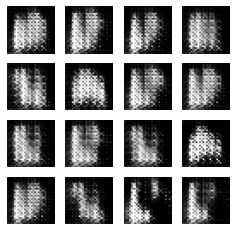

Epoch 3 | iter 51
Time for epoch 3 : 50 sec


KeyboardInterrupt: 

In [31]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

### 학습 과정 시각화하기

학습이 끝난 후 우리가 생성했던 샘플 이미지들을 합쳐 GIF 파일로 만들기!  

GIF 파일은 우리가 오래전에 import 해놓았던 `imageio` 라이브러리를 활용해 만들 수 있습니다.  

`imageio.get_writer`를 활용해서 파일을 열고, 거기에 `append_data`로 이미지를 하나씩 붙여나가는 방식입니다.  

아래 코드가 무사히 실행되면, `fasion_mnist_dcgan.gif` 파일이 저장되어 있는 것을 확인할 수 있을 겁니다!

In [ ]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif